$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$

$\newcommand{\R}{\bb{R}}$

$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$
$\newcommand{\norm}[1]{\left\Vert #1 \right\Vert}$

$\newcommand{\der}[2]{\frac{\mathrm{d} #1 }{\mathrm{d} #2 }}$
$\newcommand{\derp}[2]{\frac{\partial #1 }{\partial #2 }}$

# Finite Dimensional Koopman Bilinear System

Consider a nonlinear dynamical system that allows an exact finite dimensional Koopman canonical transform such that the control-affine dynamics can be transformed to a bilinear system. Consider the dynamical system 

\begin{equation}
\mb{\dot{x}}=\mb{f}_0(\mb x) + \mb f_1 ( \mb x) u_1 + \mb f_2(\mb x) u_2, 
\end{equation}

where we for this example choose $\mb f_0, \mb f_1$ as follows:

\begin{equation}
\mb f_0(\mb x) = \begin{bmatrix} x_3 \\ x_4 \\ \lambda x_3 \\ \mu x_4 + (2 \lambda - \mu) c x_3^2 \end{bmatrix}, \qquad
\mb f_1(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 1 \\ 0 \end{bmatrix}, \qquad
\mb f_2(\mb x) = \begin{bmatrix} 0 \\ 0 \\ 0 \\ x_1+1 \end{bmatrix}, 
\end{equation}   

and $\lambda, \mu, c \in \mathbb{R}$ are scalar parameters of the system. Setting $ \mb x = [q_1 \, q_2 \, \dot{q_1} \, \dot{q_2}]^T$, 
these equations of motion can be expressed as robotic dynamics of the form $\mb{D}(\mb{q})\ddot{\mb{q}} + \mb{C}(\mb{q}, \dot{\mb{q}})\dot{\mb{q}} + \mb{G}(\mb{q}) = \mb{B}\mb{u}$, where $\mb D$ is the inertia matrix, $\mb C$ is the matrix of Coriolis terms, $\mb G$ is the matrix of gravitational terms, and $\mb B$ is the static actuation matrix. Rewriting $\mb f_0, \mb f_1, \mb f_2$ in terms of $\mb D, \mb C, \mb G,$ and $\mb B$ yield



\begin{equation}
\mb D(\mb q) = \begin{bmatrix} 1 & 0\\ 0 &  \frac{1}{q_1+1} \end{bmatrix}, 
\qquad \mb C(\mb q, \mb{\dot{q}}) = -\begin{bmatrix} \lambda & 0 \\ \frac{1}{q_1 + 1}(2 \lambda - \mu) c \dot{q}_1 & \frac{1}{q_1 +1} \mu \end{bmatrix}, \qquad 
\mb G(\mb q) = \begin{bmatrix} 0 \\ 0 \end{bmatrix} 
\qquad \mb B = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix},
\end{equation}

In [1]:
import numpy as np
import sys
sys.path.append('../../../')

# Define experiment parameters

In [2]:
from core.dynamics import RoboticDynamics

class FiniteDimKoopSys(RoboticDynamics):
    def __init__(self, lambd, mu, c):
        RoboticDynamics.__init__(self, 2, 2)
        self.params = lambd, mu, c
    
    def D(self, q):
        return np.array([[1, 0],[0, (q[0]+1)**(-1)]])
    
    def C(self, q, q_dot):
        labmd, mu, c = self.params
        return -np.array([[lambd, 0], [(q[0]+1)**(-1)*(2*lambd - mu)*c*q_dot[0], (q[0]+1)**(-1)*mu]])
    
    def G(self, q):
        return np.array([0, 0])
    
    def B(self, q):
        return np.array([[1, 0], [0, 1]])
    
class FiniteDimKoopSysDiscrete(FiniteDimKoopSys):
    def __init__(self, lambd, mu, c, dt):
        FiniteDimKoopSys.__init__(self, lambd, mu, c)
        self.dt = dt

    def eval_dot(self, x, u, t):
        return x + self.dt*self.drift(x, t) + self.dt*np.dot(self.act(x, t),u)

    def get_linearization(self, x0, x1, u0, t):
        lambd, mu, c = self.params
        A_lin = np.eye(self.n) + self.dt*np.array([[0, 0, 1, 0],
                                            [0, 0, 0, 1],
                                            [0, 0, lambd, 0],
                                            [u0[1], 0, 2*(2*lambd-mu)*c*x0[2], mu]])

        B_lin = self.dt*np.array([[0, 0],
                          [0, 0],
                          [1, 0],
                          [0, x0[0]+1]])

        if x1 is None:
            x1 = A_lin@x0 + B_lin@u0

        f_d = self.eval_dot(x0,u0,t)
        r_lin = f_d - x1

        return A_lin, B_lin, r_lin

n, m = 4, 2
lambd, mu, c = .3, .2, -.5
finite_dim_koop_sys = FiniteDimKoopSys(lambd, mu, c)

In [3]:
from koopman_core.dynamics import LinearLiftedDynamics

A_lin = np.array([[0, 0, 1, 0],
                  [0, 0, 0, 1],
                  [0, 0, lambd, 0],
                  [0, 0, 0, mu]])
B_lin = np.array([[0, 0],
                  [0, 0],
                  [1, 0],
                  [0, 1]])
dt = 1e-2
linearized_sys = LinearLiftedDynamics(A_lin, B_lin, np.eye(n), lambda x: x)

# MPC parameters:
umax = np.array([7.5, 7.5])
umin = -umax
xmax = np.array([6., 6., 5., 5.])
xmin = -xmax
Q_mpc = 1*np.diag([1, 1, 1e-1, 1e-1])
QN_mpc = 1e4*np.eye(n)
R_mpc = np.eye(m)
traj_duration = 2
traj_length = int(traj_duration/dt)

# Design trajectory:
x0 = np.array([0., 0., 0., 0.])
set_pt = np.array([5., 3., 0., 0.])
term_constraint = True

# Define initial solution for SQP algorithm:
x_init = np.linspace(x0, set_pt, int(traj_length)+1)
u_init = np.ones((m,traj_length)).T

# Construct Koopman bilinear form of the system

As a result of the careful construction of this system, there exists a Koopman canonical transform, $\mb z = T(\mb x)$ that exactly transforms the control-affine dynamics into a bilinear system. Consider the transformation:

\begin{equation}
    T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 
    \phi_1(\mb q, \mb{\dot{q}})\\
    \phi_2(\mb q, \mb{\dot{q}})\\
    \phi_3(\mb q, \mb{\dot{q}})\\
    \phi_4(\mb q, \mb{\dot{q}})\\
    \phi_5(\mb q, \mb{\dot{q}})\\
    \phi_6(\mb q, \mb{\dot{q}})\\
    \end{bmatrix}
    = \begin{bmatrix} 
    1\\
    q_1 - \frac{1}{\lambda}\dot{q}_1\\
    q_2 - \frac{1}{\mu} \dot{q}_2 + \frac{(2 \lambda - \mu)c}{2\lambda \mu} \dot{q}_1^2\\
    \dot{q}_1\\
    \dot{q}_2 - c \dot{q}_1^2\\
    \dot{q}_1^2\\
    \end{bmatrix},
\end{equation}

where $\phi_1, \phi_2, \phi_3, \phi_4, \phi_5, \phi_6$ are eigenfunctions of the Koopman operator associated with the drift 
vector field $\mb f_0$. The matrix with the eigenvalue associated with the i-th eigenfunction on the i-th diagonal 
element is $F=\text{diag}(0, 0, \lambda, \mu, 2 \lambda, 0)$. Then, to reformulate the dynamics we have: 

\begin{equation} 
L_{\mb f_1} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0\\ -\frac{1}{\lambda}\\ \frac{(2\lambda - \mu)c}{\lambda \mu}\dot{q}_1\\ 1 \\ -2c\dot{q}_1 \\ 2\dot{q_1} \end{bmatrix}, \qquad 
L_{\mb f_2} T(\mb q, \mb{\dot{q}}) = \begin{bmatrix} 0 \\ 0\\ -\frac{1}{\mu}(q_1 + 1)\\0 \\ q_1 + 1 \\ 0 \end{bmatrix} 
\end{equation}

and the dynamics can be equivalently transformed to a bilinear form $\mb{\dot{z}} = F \mb z + G_1\mb z u_1 + G_2\mb z u_2$ with 

\begin{equation}
F = \begin{bmatrix} 
0 &0 & 0 & 0 & 0 & 0\\  
0 & 0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & 0 & 0 & 0\\
0 &0 & 0 & \lambda & 0 & 0\\
0 &0 & 0 & 0 & \mu & 0 \\
0 &0 & 0 & 0 & 0 & 2 \lambda\\
\end{bmatrix}, \qquad 
G_1 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
-\frac{1}{\lambda}& 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & \frac{(2\lambda - \mu)c}{\lambda \mu} & 0 & 0\\
1 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & -2c & 0 & 0\\
0 & 0 & 0 & 2 & 0 & 0\\  
\end{bmatrix}
, \qquad 
G_2 = \begin{bmatrix} 
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 &  0 & 0 & 0 & 0\\
 -\frac{1}{\mu} & -\frac{1}{\mu} & 0 &  -\frac{1}{\lambda \mu} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & \frac{1}{\lambda} & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\  
\end{bmatrix}
\end{equation}

In [4]:
from koopman_core.dynamics import BilinearLiftedDynamics

F = np.array([[0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [0, 0, 0, lambd, 0, 0],
              [0, 0, 0, 0, mu, 0],
              [0, 0, 0, 0, 0, 2*lambd]])
G_1 = np.array([[0, 0, 0, 0, 0, 0],
                [-1/lambd, 0, 0, 0, 0, 0],
                [0, 0, 0, (2*lambd - mu)*c/(lambd*mu), 0, 0],
                [1, 0, 0, 0, 0, 0], 
                [0, 0, 0, -2*c, 0, 0], 
                [0, 0, 0, 2, 0, 0]])
G_2 = np.array([[0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0],
                [-1/mu, -1/mu, 0, -1/(lambd*mu), 0, 0],
                [0, 0, 0, 0, 0, 0], 
                [1, 1, 0, 1/lambd, 0, 0], 
                [0, 0, 0, 0, 0, 0]])
G = [G_1, G_2]
phi_fun = lambda x: np.array([1,
                            x[0,0] - 1/lambd*x[0,2],
                            x[0,1] - 1/mu*x[0,3] + (2*lambd - mu)*c/(2*lambd*mu)*x[0,2]**2,
                            x[0,2],
                            x[0,3] - c*x[0,2]**2,
                            x[0,2]**2])
phi_fun_grad = lambda x: np.array([[0., 0., 0., 0.]
                                   [1., 0., -1/lambd, 0.],
                                   [0., 1., (2*lambd-mu)*c/(lambd*mu)*x[0,2], -1/mu],
                                   [0., 0., 1., 0.],
                                   [0., 0., -2*c*x[0,2], 1.],
                                   [0., 0., 2*x[0,2], 0.]])

C_q = np.array([[0, 1, 0, 1/lambd, 0, 0],
                [0, 0, 1, 0, 1/mu, c/mu - ((2*lambd - mu)*c)/(2*lambd*mu)]])
C_qdot = np.array([[0, 0, 0, 1, 0, 0],
                   [0, 0, 0, 0, 1, c]])
C = np.concatenate((C_q, C_qdot), axis=0)
n_koop = 6

koop_bilinear_sys = BilinearLiftedDynamics(n_koop, m, F, G, C, phi_fun)

#### Verify that the Koopman Bilinear Form model and control-affine model are equivalent

To verify that the models are in fact equivalent we sample a random control sequence and simulate both models forward with the same control sequence. As can be seen below, the resulting trajectories are equivalent.

[-5.09706565e-05 -4.05269465e-05 -1.01992309e-02 -8.10805786e-03]
[-1.54061732e-04 -6.17229227e-05 -1.04190940e-02  3.87264874e-03]
[-2.78328644e-04  3.57358248e-05 -1.44362969e-02  1.56227412e-02]
[-0.00045412  0.00017376 -0.02072482  0.01198094]
[-0.00064242  0.00029923 -0.01693392  0.01311337]
[-0.00076084  0.00042233 -0.00674404  0.01150713]
[-0.00087892  0.00054985 -0.01687666  0.01399664]
[-0.00101952  0.00066968 -0.01124191  0.0099675 ]
[-0.0011588   0.00076234 -0.01661604  0.00856506]
[-0.00136204  0.00092709 -0.02403568  0.02438996]
[-0.0015835   0.0011114  -0.02025566  0.0124681 ]
[-0.00172757  0.00126074 -0.00855176  0.01740086]
[-0.00181705  0.00134908 -0.00934413  0.00026179]
[-0.0020957   0.00132269 -0.04640526 -0.00554188]
[-0.00252166  0.00125578 -0.03878169 -0.00784063]
[-0.00285879  0.00112837 -0.02863992 -0.01764448]
[-0.00321609  0.00101836 -0.04282777 -0.00435358]
[-0.00363345  0.00094152 -0.04064236 -0.01101562]
[-0.00400995  0.0008169  -0.03465499 -0.01390906]
[-

[ 1.          0.12462861  0.45500246 -0.04578233 -0.09827739  0.00209602]
[ 1.          0.12992424  0.48567687 -0.04751096 -0.10459044  0.00225729]
[ 1.          0.19150998  0.51629959 -0.06615717 -0.11058022  0.00437677]
[ 1.          0.17902877  0.45818369 -0.06260595 -0.09924723  0.00391951]
[ 1.          0.17213287  0.39284186 -0.06072218 -0.08640704  0.00368718]
[ 1.          0.13468357  0.35190137 -0.04965296 -0.07859065  0.00246542]
[ 1.          0.08685826  0.36615068 -0.03543301 -0.08180442  0.0012555 ]
[ 1.          0.0888417   0.39224349 -0.03613539 -0.08718487  0.00130577]
[ 1.          0.10201709  0.34972877 -0.04020251 -0.07879763  0.00161624]
[ 1.          0.09408302  0.27901553 -0.03793951 -0.06482961  0.00143941]
[ 1.          0.12282551  0.30176184 -0.04668919 -0.06939149  0.00217988]
[ 1.00000000e+00  5.58725259e-02  3.46237523e-01 -2.67134116e-02
 -7.86805219e-02  7.13606360e-04]
[ 1.          0.07315951  0.38672983 -0.03198756 -0.08689382  0.0010232 ]
[ 1.         

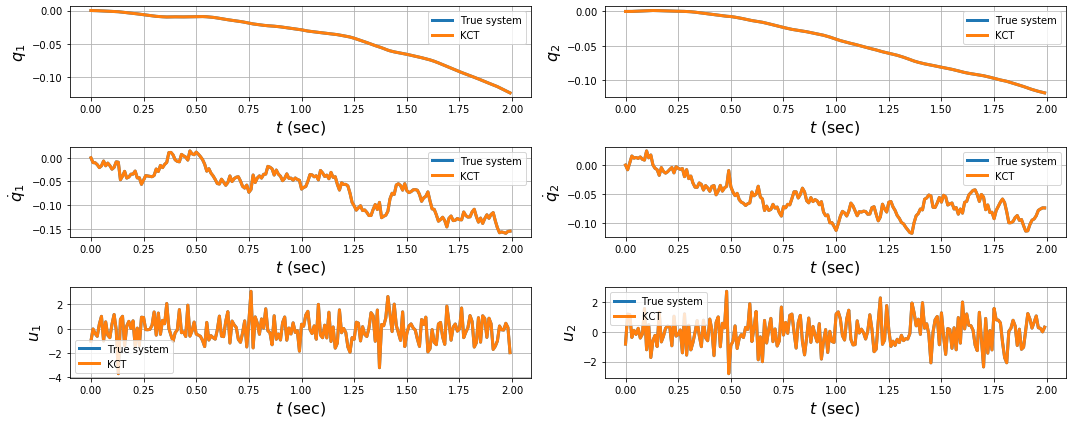

In [5]:
from matplotlib.pyplot import subplots, tight_layout, show
from koopman_core.controllers.openloop_controller import OpenLoopController

ol_controller = OpenLoopController(finite_dim_koop_sys, np.random.normal(size=(2,200)).T, np.arange(0,200)*dt)
z0 = phi_fun(x0.reshape((1,-1)))
xs, us = finite_dim_koop_sys.simulate(x0, ol_controller, np.arange(0,201)*dt)
zs_koop, us_koop = koop_bilinear_sys.simulate(z0, ol_controller, np.arange(0,201)*dt)
xs_koop = np.dot(C, zs_koop.T)

_, axs = subplots(3, 2, figsize=(15, 6))
ylabels = ['$q_1$', '$q_2$', '$\\dot{q}_1$', '$\\dot{q}_2$', '$u_1$', '$u_2$']

for ax, data_fb, data_koop, ylabel in zip(axs.flatten(), np.vstack((xs[:-1,:].T, us.T)), np.vstack((xs_koop[:,:-1], us_koop.T)), ylabels):
    ax.plot(np.arange(0,200)*dt, data_fb, linewidth=3, label='True system')
    ax.plot(np.arange(0,200)*dt, data_koop, linewidth=3, label='KCT')
    ax.set_ylabel(ylabel, fontsize=16)
    ax.grid()
    ax.set_xlabel('$t$ (sec)', fontsize=16)
    ax.legend()
    
tight_layout()
show()

# Design model predictive controllers

#### Linear model predictive controller

In [6]:
from koopman_core.controllers import MPCController

controller_lmpc = MPCController(linearized_sys, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint, add_slack=True)

#### Bilinear model predictive controller

In [7]:
from koopman_core.controllers import NonlinearMPCController, BilinearMPCController

# Define rough discrete-time model:
A_d = np.eye(n_koop) + koop_bilinear_sys.A*dt
B_d = [b*dt for b in koop_bilinear_sys.B]
kbf_d = BilinearLiftedDynamics(n_koop, m, A_d, B_d, C, koop_bilinear_sys.basis, continuous_mdl=False, dt=dt)

# Define kbf controller:
controller_knmpc = BilinearMPCController(kbf_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint)
z0 = phi_fun(x0.reshape((1,-1)))
z_init = np.array([phi_fun(x.reshape((1,-1))) for x in x_init])
controller_knmpc.construct_controller(z_init, u_init)

#### Nonlinear model predictive controller

In [8]:
finite_dim_koop_sys_d = FiniteDimKoopSysDiscrete(lambd, mu, c, dt)
controller_nmpc = NonlinearMPCController(finite_dim_koop_sys_d, traj_length, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, set_pt, terminal_constraint=term_constraint)
controller_nmpc.construct_controller(x_init, u_init)

# Evaluate performance of controllers for trajectory generation

#### Design trajectories with the constructed MPCs

In [9]:
max_iter = 50

controller_lmpc.eval(x0, 0)
xr_lmpc = controller_lmpc.parse_result()
ur_lmpc = controller_lmpc.get_control_prediction()

controller_knmpc.solve_to_convergence(z0, 0., z_init, u_init, max_iter=max_iter)
xr_knmpc = koop_bilinear_sys.C@controller_knmpc.get_state_prediction().T
ur_knmpc = controller_knmpc.get_control_prediction().T

controller_nmpc.solve_to_convergence(x0, 0., x_init, u_init, max_iter=max_iter)
xr_nmpc = controller_nmpc.get_state_prediction().T
ur_nmpc = controller_nmpc.get_control_prediction().T

#### Simulate designed trajectories open-loop

In [10]:
from koopman_core.controllers import OpenLoopController
t_eval = np.arange(0,traj_length+1)*dt
ol_controller_lmpc = OpenLoopController(finite_dim_koop_sys, ur_lmpc.T, t_eval[:-1])
xs_lmpc, us_lmpc = finite_dim_koop_sys.simulate(x0, ol_controller_lmpc, t_eval)
xs_lmpc, us_lmpc = xs_lmpc.T, us_lmpc.T

ol_controller_knmpc = OpenLoopController(finite_dim_koop_sys, ur_knmpc.T, t_eval[:-1])
xs_knmpc, us_knmpc = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc, t_eval)
xs_knmpc, us_knmpc = xs_knmpc.T, us_knmpc.T

ol_controller_nmpc = OpenLoopController(finite_dim_koop_sys, ur_nmpc.T, t_eval[:-1])
xs_nmpc, us_nmpc = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc, t_eval)
xs_nmpc, us_nmpc = xs_nmpc.T, us_nmpc.T

[0.00037542 0.00024885 0.07512159 0.04978714]
[0.00150318 0.00099227 0.15046882 0.09891817]
[0.00338555 0.0022238  0.22604238 0.14740943]
[0.00602479 0.00393711 0.30184295 0.19527547]
[0.00942317 0.00612601 0.3778712  0.24252906]
[0.01358297 0.00878443 0.45412785 0.28918119]
[0.01850619 0.0119064  0.53055293 0.33524114]
[0.02419215 0.01548605 0.60667824 0.38071704]
[0.03063392 0.01951757 0.68171194 0.4256169 ]
[0.03782059 0.02399525 0.75566078 0.46994852]
[0.04574137 0.02891342 0.82853144 0.51371859]
[0.0543855  0.03426651 0.90033058 0.5569328 ]
[0.0637423  0.04004899 0.9710648  0.59959586]
[0.07380116 0.04625535 1.04074066 0.64171148]
[0.08455151 0.05288014 1.10936469 0.68328247]
[0.09598288 0.05991793 1.17694335 0.72431071]
[0.10808485 0.06736329 1.24348308 0.76479722]
[0.12084705 0.0752108  1.30899027 0.80474216]
[0.1342592  0.08345505 1.37347125 0.84414487]
[0.14831106 0.0920906  1.43693231 0.88300391]
[0.16299246 0.10111202 1.49937971 0.92131705]
[0.1782933  0.11051382 1.56081964 

[0.00895563 0.00324674 0.35318357 0.12828045]
[0.01282184 0.00465217 0.42009118 0.15281234]
[0.01735117 0.00630128 0.48580814 0.17701597]
[0.02253183 0.00819088 0.55035706 0.2009093 ]
[0.02835226 0.01031795 0.61375992 0.22450939]
[0.03480109 0.01267963 0.67603809 0.24783244]
[0.04186719 0.01527323 0.73721228 0.27089389]
[0.04953962 0.01809621 0.79730264 0.29370844]
[0.05780763 0.02114618 0.85632875 0.31629015]
[0.06666067 0.02442086 0.91430962 0.33865243]
[0.0760884  0.02791814 0.97126375 0.36080816]
[0.08608062 0.031636   1.02720908 0.38276963]
[0.09662735 0.03557256 1.08216308 0.40454866]
[0.10771874 0.03972605 1.13614273 0.42615656]
[0.11934514 0.04409483 1.18916452 0.44760421]
[0.13149706 0.04867732 1.24124449 0.46890202]
[0.14416514 0.0534721  1.29239824 0.49006   ]
[0.15734021 0.0584778  1.34264094 0.51108773]
[0.17101323 0.06369317 1.39198734 0.5319944 ]
[0.18517531 0.06911704 1.44045176 0.5527888 ]
[0.19981769 0.07474833 1.48804816 0.57347932]
[0.21493176 0.08058605 1.5347901  

[4.61134502 2.34801812 2.14242019 0.52905219]
[4.63262213 2.35308745 2.11298714 0.48481871]
[4.65360294 2.35770989 2.08315975 0.43967354]
[4.6742835  2.36187623 2.05293736 0.39359774]
[4.69465986 2.36557707 2.02231932 0.34657187]
[4.71472806 2.3688028  1.99130494 0.29857606]
[4.73448413 2.37154363 1.95989352 0.24958996]
[4.7539241  2.37378954 1.92808438 0.19959284]
[4.77304399 2.37553032 1.89587679 0.14856358]
[4.7918398  2.37675555 1.86327005 0.09648067]
[4.81030755 2.37745457 1.83026344 0.04332232]
[ 4.82844324  2.37761653  1.79685623 -0.01093357]
[ 4.84624284  2.37723033  1.76304769 -0.06630938]
[ 4.86370235  2.37628467  1.7288371  -0.12282767]
[ 4.88081774  2.37476799  1.69422372 -0.18051121]
[ 4.89758498  2.37266855  1.65920682 -0.23938288]
[ 4.91400003  2.36997434  1.62378569 -0.29946566]
[0.00037538 0.00014179 0.07511261 0.02836682]
[0.001503   0.00056535 0.1504509  0.0563539 ]
[0.00338515 0.00126699 0.22601554 0.08398256]
[0.00602407 0.00224322 0.30180722 0.11127225]
[0.0094220

[5.00444348 3.05254959 0.28570014 0.34070487]
[5.00695274 3.05560717 0.21611785 0.27079302]
[5.00876261 3.05795731 0.1458202  0.19921673]
[5.00986592 3.05958323 0.07480664 0.12594538]
[5.01025552e+00 3.06046782e+00 3.07665710e-03 5.09482915e-02]


#### Plot/analyze the results

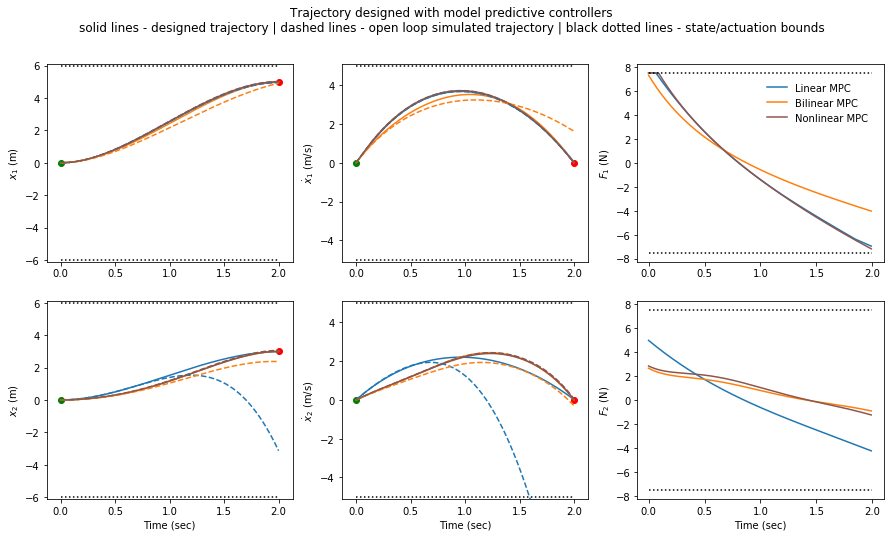

Quadratic cost (normalized by NMPC cost) of designed and realized trajectories designed with each MPC:

                        Designed trajectory    Realized trajectory
--------------------  ---------------------  ---------------------
Linear MPC                         1.18108               547.005
Koopman bilinear MPC               0.495652                7.55153
Nonlinear MPC                      1                       1


In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate

plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Trajectory designed with model predictive controllers\nsolid lines - designed trajectory | dashed lines - open loop simulated trajectory | black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xr_lmpc[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xr_knmpc[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xr_nmpc[ind,:], colors[2], label='Nonlinear MPC')

        plt.plot(t_eval, xs_lmpc[ind,:], '--', color=colors[0])
        plt.plot(t_eval, xs_knmpc[ind, :], '--', color=colors[1])
        plt.plot(t_eval, xs_nmpc[ind,:], '--', color=colors[2])

        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],ur_lmpc[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], ur_knmpc[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],ur_nmpc[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_ref_lmpc = (xr_lmpc[:,-1]-set_pt).T@QN_mpc@(xr_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ref_knmpc = (xr_knmpc[:,-1]-set_pt).T@QN_mpc@(xr_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ref_nmpc = (xr_nmpc[:,-1]-set_pt).T@QN_mpc@(xr_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

cost_ol_lmpc = (xs_lmpc[:,-1]-set_pt).T@QN_mpc@(xs_lmpc[:,-1]-set_pt) + np.sum(np.diag(ur_lmpc.T@R_mpc@ur_lmpc))
cost_ol_knmpc = (xs_knmpc[:,-1]-set_pt).T@QN_mpc@(xs_knmpc[:,-1]-set_pt) + np.sum(np.diag(ur_knmpc.T@R_mpc@ur_knmpc))
cost_ol_nmpc = (xs_nmpc[:,-1]-set_pt).T@QN_mpc@(xs_nmpc[:,-1]-set_pt) + np.sum(np.diag(ur_nmpc.T@R_mpc@ur_nmpc))

print('Quadratic cost (normalized by NMPC cost) of designed and realized trajectories designed with each MPC:\n')
print(tabulate([['Linear MPC', cost_ref_lmpc/cost_ref_nmpc, cost_ol_lmpc/cost_ol_nmpc], 
                ['Koopman bilinear MPC', cost_ref_knmpc/cost_ref_nmpc, cost_ol_knmpc/cost_ol_nmpc],
                ['Nonlinear MPC', 1, 1]], 
               headers=['Designed trajectory', 'Realized trajectory']))

#### Study evolution of the solution after each iteration of the SQP-algorithm

[5.00500375e-05 5.00336001e-05 1.00150150e-02 1.00101067e-02]
[0.0002004  0.00020027 0.02006012 0.02004085]
[0.00045135 0.00045092 0.03013541 0.03009288]
[0.00080321 0.0008022  0.04024096 0.04016683]
[0.00125627 0.00125433 0.05037688 0.05026335]
[0.00181085 0.00180755 0.06054325 0.06038308]
[0.00246724 0.00246207 0.07074017 0.07052665]
[0.00322575 0.00321816 0.08096773 0.08069473]
[0.0040867  0.00407605 0.09122601 0.09088794]
[0.00505038 0.00503601 0.10151511 0.10110694]
[0.0061171  0.00609828 0.11183513 0.11135237]
[0.00728718 0.00726314 0.12218615 0.12162488]
[0.00856093 0.00853087 0.13256828 0.13192511]
[0.00993865 0.00990174 0.1429816  0.14225371]
[0.01142067 0.01137604 0.1534262  0.15261134]
[0.01300728 0.01295407 0.16390218 0.16299863]
[0.01469881 0.01463611 0.17440964 0.17341624]
[0.01649558 0.01642249 0.18494867 0.18386481]
[0.01839789 0.01831352 0.19551937 0.194345  ]
[0.02040607 0.0203095  0.20612182 0.20485746]
[0.02252044 0.02241077 0.21675613 0.21540283]
[0.0247413  0.0246

[0.65472306 0.22893893 2.44562916 0.93720583]
[0.67933441 0.23839004 2.47665638 0.95303543]
[0.70425212 0.24799791 2.5069016  0.96855706]
[0.72946841 0.25775941 2.53636988 0.98376251]
[0.75497552 0.26767135 2.56506621 0.99864362]
[0.78076575 0.27773043 2.59299554 1.01319228]
[0.80683148 0.28793329 2.62016275 1.02740047]
[0.83316509 0.29827649 2.64657269 1.04126022]
[0.85975904 0.30875651 2.67223012 1.05476369]
[0.88660583 0.31936974 2.69713979 1.06790313]
[0.913698   0.33011251 2.72130636 1.0806709 ]
[0.94102814 0.34098106 2.74473445 1.09305949]
[0.9685889  0.35197156 2.76742862 1.10506156]
[0.99637296 0.36308011 2.78939338 1.11666989]
[1.02437304 0.37430274 2.81063319 1.12787745]
[1.05258191 0.38563541 2.83115245 1.13867738]
[1.0809924  0.397074   2.8509555  1.14906301]
[1.10959737 0.40861435 2.87004665 1.1590279 ]
[1.1383897  0.42025221 2.88843012 1.16856578]
[1.16736236 0.43198328 2.9061101  1.17767065]
[1.19650832 0.44380321 2.92309072 1.18633674]
[1.22582061 0.45570758 2.93937606 

[2.17682474 0.74803504 3.1173172  0.8737168 ]
[2.20797896 0.7566866  3.11352643 0.85659938]
[2.23909239 0.7651637  3.10915582 0.8388225 ]
[2.27015922 0.77345974 3.10420766 0.82039016]
[2.30117369 0.78156822 3.09868418 0.80130674]
[2.33213006 0.78948262 3.09258755 0.78157695]
[2.36302262 0.79719652 3.08591989 0.76120588]
[2.39384565 0.80470353 3.07868326 0.74019895]
[2.42459349 0.81199733 3.0708797  0.71856192]
[2.45526046 0.81907163 3.06251117 0.69630088]
[2.48584094 0.82592023 3.05357958 0.67342223]
[2.51632929 0.83253699 3.0440868  0.64993268]
[2.54671992 0.83891584 3.03403466 0.62583925]
[2.57700725 0.84505077 3.02342491 0.6011492 ]
[2.6071857  0.85093585 3.01225927 0.57587012]
[2.63724972 0.85656524 3.00053942 0.5500098 ]
[2.66719378 0.86193316 2.98826697 0.52357633]
[2.69701237 0.86703392 2.97544349 0.49657799]
[2.72669997 0.87186191 2.9620705  0.46902331]
[2.75625111 0.87641162 2.94814948 0.44092099]
[2.7856603  0.88067761 2.93368186 0.41227995]
[2.81492209 0.88465454 2.918669   

[2.76261789 1.3237777  3.52738364 2.15967185]
[2.79785438 1.34539835 3.51991142 2.16451639]
[2.83301309 1.36706453 3.51182571 2.16877741]
[2.86808788 1.38877037 3.50312826 2.17244985]
[2.90307265 1.41050998 3.49382072 2.17552894]
[2.9379613  1.43227739 3.48390475 2.17801026]
[2.97274776 1.4540666  3.47338195 2.17988965]
[3.00742597 1.47587159 3.46225387 2.1811633 ]
[3.04198988 1.49768626 3.45052204 2.18182767]
[3.07643346 1.51950452 3.43818794 2.18187952]
[3.1107507  1.54132022 3.42525301 2.18131588]
[3.14493559 1.56312719 3.41171866 2.18013404]
[3.17898215 1.58491925 3.39758626 2.17833157]
[3.2128844  1.60669016 3.38285714 2.17590625]
[3.24663639 1.62843371 3.36753257 2.17285613]
[3.28023216 1.65014362 3.35161382 2.16917946]
[3.31366578 1.67181362 3.33510208 2.16487467]
[3.34693133 1.69343743 3.31799854 2.15994043]
[3.38002289 1.71500875 3.30030433 2.15437554]
[3.41293456 1.73652126 3.28202053 2.14817898]
[3.44566045 1.75796865 3.26314821 2.14134985]
[3.47819468 1.77934458 3.24368837 

[2.64135045 1.2389886  3.71770625 2.23723502]
[2.67850677 1.26141307 3.71355599 2.24773014]
[2.71561806 1.2839398  3.7086989  2.25768689]
[2.75267725 1.30656337 3.70313593 2.26709715]
[2.78967728 1.32927827 3.69686798 2.27595311]
[2.82661112 1.35207892 3.68989591 2.28424731]
[2.86347172 1.37495967 3.68222058 2.29197259]
[2.90025206 1.3979148  3.6738428  2.29912213]
[2.93694511 1.42093851 3.66476337 2.30568945]
[2.97354387 1.44402495 3.65498305 2.31166838]
[3.01004132 1.46716822 3.64450257 2.31705309]
[3.04643048 1.49036233 3.63332266 2.32183807]
[3.08270434 1.51360127 3.62144399 2.32601811]
[3.11885593 1.53687896 3.60886723 2.32958831]
[3.15487826 1.56018928 3.59559301 2.3325441 ]
[3.19076437 1.58352606 3.58162194 2.33488116]
[3.22650729 1.60688311 3.56695462 2.3365955 ]
[3.26210006 1.63025417 3.55159159 2.33768336]
[3.29753573 1.65363296 3.5355334  2.33814128]
[3.33280734 1.67701316 3.51878055 2.33796603]
[3.36790795 1.70038843 3.50133354 2.33715462]
[3.40283063 1.7237524  3.48319283 

[2.07752949 0.91858465 3.70249489 2.03825767]
[2.11459096 0.9390584  3.70980369 2.05656319]
[2.15172191 0.95971332 3.71638919 2.07449373]
[2.1889151  0.98054562 3.72225221 2.09203613]
[2.22616332 1.00155133 3.72739355 2.10917739]
[2.26345935 1.02272638 3.73181395 2.12590466]
[2.30079598 1.04406657 3.73551409 2.14220526]
[2.33816601 1.06556757 3.73849463 2.15806674]
[2.37556226 1.08722492 3.74075615 2.17347684]
[2.41297753 1.10903407 3.74229923 2.18842353]
[2.45040465 1.1309903  3.74312437 2.20289505]
[2.48783643 1.15308881 3.74323205 2.21687989]
[2.52526571 1.17532469 3.74262272 2.2303668 ]
[2.56268531 1.19769289 3.74129676 2.24334483]
[2.60008807 1.22018827 3.73925455 2.25580335]
[2.63746683 1.24280559 3.7364964  2.26773199]
[2.67481443 1.26553949 3.73302263 2.27912074]
[2.71212373 1.28838454 3.72883348 2.28995989]
[2.74938755 1.31133518 3.7239292  2.30024008]
[2.78659876 1.33438579 3.71830997 2.30995227]
[2.82375021 1.35753063 3.71197596 2.31908777]
[2.86083474 1.38076391 3.70492733 

[2.31206143 1.04019124 3.71980884 2.1479444 ]
[2.34926948 1.06175603 3.72180298 2.16508946]
[2.38649393 1.08349022 3.72308788 2.18182457]
[2.4237277  1.10538964 3.72366485 2.19813704]
[2.4609637  1.12745002 3.72353516 2.21401441]
[2.49819488 1.14966693 3.72270003 2.2294444 ]
[2.53541418 1.17203585 3.72116063 2.24441499]
[2.57261458 1.19455212 3.71891809 2.25891439]
[2.60978905 1.21721096 3.7159735  2.27293106]
[2.64693056 1.24000751 3.71232791 2.28645373]
[2.68403213 1.26293675 3.70798232 2.29947143]
[2.72108674 1.2859936  3.70293769 2.31197343]
[2.75808742 1.30917284 3.69719494 2.32394934]
[2.79502718 1.33246915 3.69075498 2.33538905]
[2.83189907 1.35587714 3.68361863 2.34628277]
[2.86869611 1.37939128 3.67578673 2.35662101]
[2.90541137 1.40300599 3.66726004 2.36639461]
[2.94203789 1.42671556 3.65803933 2.37559473]
[2.97856874 1.45051423 3.64812528 2.38421285]
[3.01499698 1.47439613 3.63751859 2.39224076]
[3.0513157  1.49835532 3.6262199  2.39967059]
[3.08751798 1.52238578 3.61422983 

[2.34821376 1.08465193 3.59176754 2.09401499]
[2.3841416  1.10565624 3.59380172 2.10690873]
[2.42008681 1.12678711 3.59523989 2.11932513]
[2.45604342 1.1480397  3.5960836  2.13125381]
[2.49200551 1.16940909 3.59633436 2.14268468]
[2.52796715 1.19089025 3.59599363 2.15360795]
[2.56392244 1.21247807 3.59506282 2.16401411]
[2.59986547 1.23416731 3.59354332 2.17389398]
[2.63579037 1.25595268 3.59143645 2.1832387 ]
[2.67169128 1.27782877 3.58874351 2.19203973]
[2.70756233 1.29979012 3.58546575 2.20028887]
[2.7433977  1.32183117 3.58160441 2.20797824]
[2.77919153 1.34394627 3.57716066 2.21510031]
[2.81493803 1.36612973 3.57213564 2.22164788]
[2.85063137 1.38837575 3.56653046 2.22761408]
[2.88626577 1.4106785  3.56034621 2.2329924 ]
[2.92183544 1.43303206 3.55358391 2.23777666]
[2.9573346  1.45543047 3.54624458 2.241961  ]
[2.99275749 1.47786769 3.53832919 2.2455399 ]
[3.02809835 1.50033766 3.52983868 2.24850816]
[3.06335143 1.52283423 3.52077395 2.25086091]
[3.09851101 1.54535122 3.51113589 

[2.64710466 1.24036019 3.71245542 2.28759314]
[2.68420744 1.2633007  3.70809748 2.30058426]
[2.72126314 1.28636853 3.70304047 2.31305785]
[2.75826478 1.30955847 3.69728533 2.32500357]
[2.79520539 1.33286516 3.69083296 2.33641136]
[2.83207799 1.3562832  3.68368423 2.34727148]
[2.86887564 1.37980706 3.67583998 2.35757452]
[2.90559136 1.40343112 3.66730098 2.36731136]
[2.94221823 1.42714967 3.65806801 2.37647325]
[2.9787493  1.45095692 3.6481418  2.38505171]
[3.01517765 1.47484701 3.63752302 2.39303862]
[3.05149636 1.49881396 3.62621235 2.40042618]
[3.0876985  1.52285176 3.61421041 2.4072069 ]
[3.12377718 1.5469543  3.60151779 2.41337361]
[3.15972547 1.57111541 3.58813507 2.41891945]
[3.1955365  1.59532883 3.57406278 2.42383789]
[3.23120336 1.61958828 3.55930143 2.42812267]
[3.26671916 1.64388738 3.54385149 2.43176784]
[3.30207702 1.6682197  3.52771341 2.43476774]
[3.33727007 1.69257877 3.51088761 2.43711696]
[3.37229143 1.71695806 3.4933745  2.43881038]
[3.40713422 1.74135098 3.47517442 

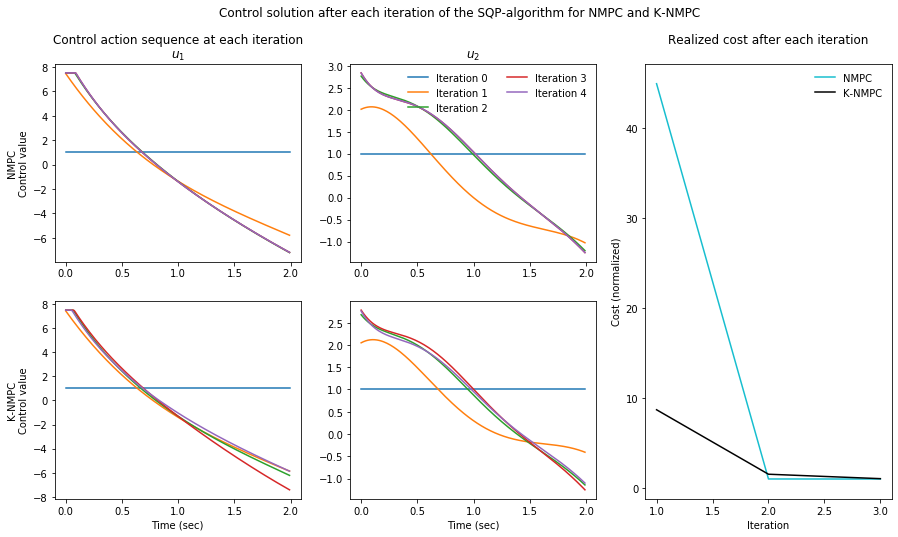

Solution statistics

                        Number of SQP    Mean comp. time per    Std comp. time per    Total comp.
                           iterations       iteration (secs)      iteration (secs)    time (secs)
--------------------  ---------------  ---------------------  --------------------  -------------
Nonlinear MPC                       4              0.0286474            0.00157508        0.11459
Koopman bilinear MPC               50              0.0150752            0.00582501        0.75376


In [12]:
n_iter = min(len(controller_nmpc.x_iter),len(controller_knmpc.x_iter))

# Calculate cost after each iteration:
iter_cost_nmpc, iter_cost_knmpc = [], []

ol_controller_init = OpenLoopController(finite_dim_koop_sys, u_init, t_eval[:-1])
xs_init, _ = finite_dim_koop_sys.simulate(x0, ol_controller_init, t_eval)
xs_init, us_init = xs_init.T, u_init.T
init_cost = (xs_init[:,-1]-set_pt).T@QN_mpc@(xs_init[:,-1]-set_pt) + np.sum(np.diag(us_init.T@R_mpc@us_init))
iter_cost_nmpc = [init_cost]
iter_cost_knmpc = [init_cost]

for ii in range(n_iter):
    ur_knmpc_iter = controller_knmpc.u_iter[ii].T
    ol_controller_knmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_knmpc_iter, t_eval[:-1])
    xs_knmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_knmpc_iter, t_eval)
    xs_knmpc_iter, us_knmpc_iter = xs_knmpc_iter.T, ur_knmpc_iter.T
    iter_cost_knmpc.append((xs_knmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_iter.T@R_mpc@us_knmpc_iter)))
    
    ur_nmpc_iter = controller_nmpc.u_iter[ii].T
    ol_controller_nmpc_iter = OpenLoopController(finite_dim_koop_sys, ur_nmpc_iter, t_eval[:-1])
    xs_nmpc_iter, _ = finite_dim_koop_sys.simulate(x0, ol_controller_nmpc_iter, t_eval)
    xs_nmpc_iter, us_nmpc_iter = xs_nmpc_iter.T, ur_nmpc_iter.T
    iter_cost_nmpc.append((xs_nmpc_iter[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_iter[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_iter.T@R_mpc@us_nmpc_iter)))

plt.figure(figsize=(15,8))
plt.suptitle('Control solution after each iteration of the SQP-algorithm for NMPC and K-NMPC')
ax1 = plt.subplot(2,3,1)
ax1.plot(t_eval[:-1],u_init[:, 0])
ax2 = plt.subplot(2,3,2)
ax2.plot(t_eval[:-1],u_init[:, 1], label='Iteration 0')
ax3 = plt.subplot(2,3,4)
ax3.plot(t_eval[:-1],u_init[:, 0])
ax4 = plt.subplot(2,3,5)
ax4.plot(t_eval[:-1],u_init[:, 0])

for it in range(n_iter):
    ax1.plot(t_eval[:-1],controller_nmpc.u_iter[it][0,:])
    ax2.plot(t_eval[:-1],controller_nmpc.u_iter[it][1,:], label='Iteration '+str(it+1))
    ax3.plot(t_eval[:-1],controller_knmpc.u_iter[it][0,:])
    ax4.plot(t_eval[:-1],controller_knmpc.u_iter[it][1,:])
    
ax5 = plt.subplot(1,3,3)
ax5.plot(np.arange(1,n_iter), iter_cost_nmpc[1:n_iter]/iter_cost_nmpc[-1], 'tab:cyan', label='NMPC')
ax5.plot(np.arange(1,n_iter), iter_cost_knmpc[1:n_iter]/iter_cost_nmpc[-1], 'k', label='K-NMPC')

ax1.set_title('Control action sequence at each iteration\n$u_1$')
ax1.set_ylabel('NMPC\nControl value')
ax2.set_title('$u_2$')
ax2.legend(ncol=2, loc='upper right', frameon=False)
ax3.set_ylabel('K-NMPC\nControl value')
ax3.set_xlabel('Time (sec)')
ax4.set_xlabel('Time (sec)')
ax5.set_title('Realized cost after each iteration\n')
ax5.set_xlabel('Iteration')
ax5.set_ylabel('Cost (normalized)')
ax5.legend(loc='upper right', frameon=False)

plt.show()

print('Solution statistics\n')
print(tabulate([['Nonlinear MPC', len(controller_nmpc.x_iter), np.mean(controller_nmpc.comp_time), np.std(controller_nmpc.comp_time), sum(controller_nmpc.comp_time)],
                ['Koopman bilinear MPC', len(controller_knmpc.x_iter), np.mean(controller_knmpc.comp_time), np.std(controller_knmpc.comp_time), sum(controller_knmpc.comp_time)]], 
               headers=['Number of SQP\niterations','Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)', 'Total comp.\ntime (secs)']))

# Evaluate performance of controllers for closed-loop control

#### Design finite horizon controllers

In [13]:
Q_mpc_cl = 1e2*np.diag([1, 1, 2e-1, 2e-1])
QN_mpc_cl= Q_mpc_cl
R_mpc_cl = np.eye(m)
traj_duration = 0.5
N_cl = int(traj_duration/dt)

controller_lmpc_cl = MPCController(linearized_sys, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False, add_slack=True)
controller_knmpc_cl = BilinearMPCController(kbf_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False, add_slack=True)
controller_knmpc_cl.construct_controller(controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:])
controller_nmpc_cl = NonlinearMPCController(finite_dim_koop_sys_d, N_cl, dt, umin, umax, xmin, xmax, Q_mpc_cl, R_mpc_cl, QN_mpc_cl, set_pt, terminal_constraint=False)
controller_nmpc_cl.construct_controller(controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:])

In [14]:
controller_knmpc_cl.solve_to_convergence(z0, 0., controller_knmpc.cur_z[:N_cl+1,:], controller_knmpc.cur_u[:N_cl,:], max_iter=max_iter)
controller_nmpc_cl.solve_to_convergence(x0, 0., controller_nmpc.cur_z[:N_cl+1,:], controller_nmpc.cur_u[:N_cl,:], max_iter=max_iter)

#### Simulate designed trajectories closed-loop

In [15]:
xs_lmpc_cl, us_lmpc_cl = finite_dim_koop_sys.simulate(x0, controller_lmpc_cl, t_eval)
xs_lmpc_cl, us_lmpc_cl = xs_lmpc_cl.T, us_lmpc_cl.T

controller_knmpc_cl.comp_time = []
xs_knmpc_cl, us_knmpc_cl = finite_dim_koop_sys.simulate(x0, controller_knmpc_cl, t_eval)
xs_knmpc_cl, us_knmpc_cl = xs_knmpc_cl.T, us_knmpc_cl.T

controller_nmpc_cl.comp_time = []
xs_nmpc_cl, us_nmpc_cl = finite_dim_koop_sys.simulate(x0, controller_nmpc_cl, t_eval)
xs_nmpc_cl, us_nmpc_cl = xs_nmpc_cl.T, us_nmpc_cl.T

[0.00037537 0.00037526 0.0751125  0.07508058]
[0.00150301 0.00150223 0.15045156 0.15034617]
[0.00338516 0.00338291 0.22601695 0.22582993]
[0.0060241  0.00601967 0.30180941 0.30156602]
[0.00942211 0.00941519 0.3778296  0.37758858]
[0.01358146 0.01357251 0.45407818 0.45393183]
[0.01850443 0.01849501 0.53055586 0.53062997]
[0.02419334 0.02418641 0.60726331 0.60771724]
[0.03065047 0.03065077 0.68420125 0.68522798]
[0.03787813 0.03789249 0.76137034 0.76319646]
[0.04587865 0.04591634 0.83877131 0.84165707]
[0.05465434 0.05472739 0.91640496 0.92064413]
[0.06420753 0.06433109 0.99427175 1.0001929 ]
[0.07454055 0.07473323 1.07237253 1.08033609]
[0.08565576 0.08593991 1.15070795 1.16110893]
[0.0975555  0.09795762 1.22927876 1.24254585]
[0.11024212 0.11079316 1.30808562 1.32468123]
[0.123718   0.12445369 1.38712928 1.40754958]
[0.1379855  0.13894671 1.46641043 1.49118548]
[0.153047   0.15428007 1.5459298  1.57562382]
[0.16890489 0.17046197 1.62568809 1.66089832]
[0.18556156 0.18750097 1.70568602 

[0.00602409 0.00601966 0.30180806 0.30156439]
[0.00942208 0.00941515 0.37782745 0.37758608]
[0.0135814  0.01357245 0.45407525 0.45392843]
[0.01850435 0.01849491 0.53055213 0.53062568]
[0.02419321 0.02418626 0.60725879 0.60771207]
[0.03065029 0.03065056 0.68419591 0.68522195]
[0.0378779  0.03789222 0.76136419 0.76318951]
[0.04587835 0.04591599 0.83876433 0.84164914]
[0.05465396 0.05472696 0.91639701 0.92063521]
[0.06420707 0.06433056 0.99426294 1.00018211]
[0.07454    0.07473258 1.07236282 1.08032424]
[0.08565511 0.08593915 1.15069735 1.16109604]
[0.09755473 0.09795672 1.22926724 1.24253196]
[0.11024124 0.11079211 1.30807319 1.32466648]
[0.12371699 0.12445249 1.38711595 1.40753411]
[0.13798435 0.13894536 1.46639619 1.49116935]
[0.1530457  0.15427855 1.54591462 1.57560672]
[0.16890344 0.17046028 1.62567194 1.66088075]
[0.18555994 0.18749907 1.70566849 1.74702646]
[0.20301761 0.20540383 1.78590579 1.83407756]
[0.22127886 0.22418376 1.86638417 1.9220691 ]
[0.2403461  0.2438415  1.94710432 

[0.0185043  0.01849486 0.53055129 0.53062484]
[0.02419316 0.0241862  0.60725795 0.60771123]
[0.03065023 0.0306505  0.68419507 0.68522104]
[0.03787783 0.03789215 0.76136335 0.7631886 ]
[0.04587827 0.04591591 0.83876348 0.84164823]
[0.05465387 0.05472687 0.91639616 0.92063429]
[0.06420697 0.06433046 0.99426209 1.00018118]
[0.0745399  0.07473248 1.07236197 1.08032331]
[0.08565499 0.08593903 1.1506965  1.1610951 ]
[0.09755461 0.09795659 1.22926638 1.24253102]
[0.11024111 0.11079198 1.30807233 1.32466553]
[0.12371685 0.12445235 1.38711501 1.40753316]
[0.1379842  0.1389452  1.4663952  1.49116837]
[0.15304554 0.15427839 1.5459136  1.57560572]
[0.16890327 0.1704601  1.62567092 1.66087975]
[0.18555976 0.18749889 1.70566787 1.74702503]
[0.20301743 0.20540362 1.78590517 1.83407613]
[0.22127867 0.22418354 1.86638335 1.92206763]
[0.2403459  0.24384823 1.94710352 2.01103417]
[0.26022155 0.26439982 2.02806621 2.09945146]
[0.28090803 0.28581219 2.10927216 2.1831763 ]
[0.3024078  0.30803878 2.19072209 

[4.40428031 2.78332295 0.92542162 0.3700871 ]
[4.4134647  2.7869926  0.91145116 0.36384821]
[4.4225104  2.79060039 0.89768023 0.35771349]
[4.43141936 2.79414734 0.88410643 0.35168123]
[4.44019357 2.79763447 0.87072737 0.34574976]
[4.44883494 2.80106279 0.85754066 0.33991742]
[4.45734539 2.80443326 0.84454395 0.3341826 ]
[4.46572682 2.80774688 0.83173486 0.32854368]
[4.47398108 2.81100457 0.81911107 0.32299911]
[4.48211002 2.81420728 0.80667023 0.31754732]
[4.49011545 2.81735594 0.79441003 0.3121868 ]
[4.49799917 2.82045143 0.78232819 0.30691605]
[4.50576296 2.82349466 0.7704224  0.30173358]
[4.51340855 2.82648651 0.75869042 0.29663795]
[4.52093768 2.82942782 0.74712998 0.29162772]


#### Plot/analyze the results

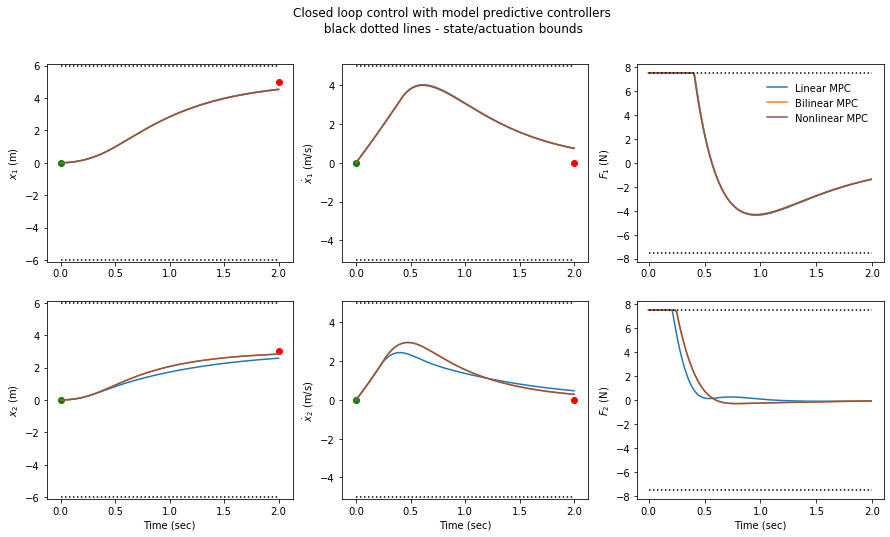


Solution statistics:

                        Quadratic cost    Mean comp. time per    Std comp. time per
                          (normalized)       iteration (secs)      iteration (secs)
--------------------  ----------------  ---------------------  --------------------
Linear MPC                     1.13979            0.000278711           8.73021e-05
Koopman bilinear MPC           0.99999            0.0022709             0.000342695
Nonlinear MPC                  1                  0.00782883            0.00131393


In [16]:
plot_inds = [0, 2, 1, 3, 0, 1]
subplot_inds = [1, 2, 4, 5, 3, 6]
labels = ['$x_1$ (m)', '$x_2$ (m)', '$\\dot{x}_1$ (m/s)','$\\dot{x}_2$ (m/s)','$F_1$ (N)','$F_2$ (N)']
colors = ['tab:blue', 'tab:orange', 'tab:brown']

plt.figure(figsize=(15,8))
plt.suptitle('Closed loop control with model predictive controllers\n black dotted lines - state/actuation bounds')
for ii in range(6):
    ind = plot_inds[ii]
    if ii < 4:
        plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval, xs_lmpc_cl[ind,:], colors[0], label='Linear MPC')
        plt.plot(t_eval, xs_knmpc_cl[ind, :], colors[1], label='Bilinear MPC')
        plt.plot(t_eval, xs_nmpc_cl[ind,:], colors[2], label='Nonlinear MPC')
        
        #plt.plot(t_eval, xr_lmpc[ind,:], '--', color=colors[0], linewidth=1)
        #plt.plot(t_eval, xr_knmpc[ind, :], '--', color=colors[1], linewidth=1)
        #plt.plot(t_eval, xr_nmpc[ind,:], '--', color=colors[2], linewidth=1)

        plt.plot([0, 2.], [xmax[ind], xmax[ind]], ':k')
        plt.plot([0, 2.], [xmin[ind], xmin[ind]], ':k')
        plt.scatter(t_eval[0], x0[ind], color='g')
        plt.scatter(t_eval[-1], set_pt[ind], color='r')
        plt.ylabel(labels[ind])
        plt.ylim(xmin[ind]-0.1,xmax[ind]+0.1)
    else:
        ax = plt.subplot(2,3,subplot_inds[ii])
        plt.plot(t_eval[:-1],us_lmpc_cl[ind,:], color=colors[0], label='Linear MPC')
        plt.plot(t_eval[:-1], us_knmpc_cl[ind, :], color=colors[1], label='Bilinear MPC')
        plt.plot(t_eval[:-1],us_nmpc_cl[ind,:], color=colors[2], label='Nonlinear MPC')
        plt.plot([0, 2.], [umax[ind], umax[ind]], ':k')
        plt.plot([0, 2.], [umin[ind], umin[ind]], ':k')
        plt.ylabel(labels[ii])
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        if subplot_inds[ii]==3:
            plt.legend(loc='upper right', bbox_to_anchor=(0.975, 0.95), frameon=False)
    if subplot_inds[ii] == 4 or subplot_inds[ii] == 5 or subplot_inds[ii] == 6:
        plt.xlabel('Time (sec)')
            
plt.show()

cost_cl_lmpc = np.sum(np.diag((xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_lmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_lmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_lmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_lmpc_cl.T@R_mpc@us_lmpc_cl))
cost_cl_knmpc = np.sum(np.diag((xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_knmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_knmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_knmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_knmpc_cl.T@R_mpc@us_knmpc_cl))
cost_cl_nmpc = np.sum(np.diag((xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)).T@Q_mpc@(xs_nmpc_cl[:,:-1]-set_pt.reshape(-1,1)))) + (xs_nmpc_cl[:,-1]-set_pt).T@QN_mpc@(xs_nmpc_cl[:,-1]-set_pt) + np.sum(np.diag(us_nmpc_cl.T@R_mpc@us_nmpc_cl))


print('\nSolution statistics:\n')
print(tabulate([['Linear MPC', cost_cl_lmpc/cost_cl_nmpc, np.mean(controller_lmpc_cl.comp_time), np.std(controller_lmpc_cl.comp_time)],
                ['Koopman bilinear MPC', cost_cl_knmpc/cost_cl_nmpc, np.mean(controller_knmpc_cl.comp_time), np.std(controller_knmpc_cl.comp_time)], 
                ['Nonlinear MPC', cost_cl_nmpc/cost_cl_nmpc, np.mean(controller_nmpc_cl.comp_time), np.std(controller_nmpc_cl.comp_time)]],
               headers=['Quadratic cost\n(normalized)', 'Mean comp. time per\niteration (secs)', 'Std comp. time per\niteration (secs)']))